# Predicting OMP output using T, S, lon, lat, depth

**1. Load training data from .nc file into dataframe**

In [15]:
import pandas as pd
from netCDF4 import Dataset
import xarray as xr

training_data = xr.open_dataset("/Users/ko389/Documents/GitHub/Arctic_water_masses/Data/OMP_output.nc").to_dataframe()


**2. Add/modify input features**

In [2]:
# Change longitude from -180 to 180 to a continuous feature

import numpy as np
training_data['lon_sin'] = np.sin(np.radians(training_data['longitude']))
training_data['lon_cos'] = np.cos(np.radians(training_data['longitude']))



In [3]:

# Change time to a continous & categorical feature

# Define the function to add a seasonal sine feature to a DataFrame
def add_seasonal_sin_feature_to_df(df):

    # Extract the month and day from the datetime array
    months = df['datetime'].dt.month
    days = df['datetime'].dt.day

    # Convert month and day to radians
    month_radians = 2 * np.pi * (months - 1) / 12
    day_radians = 2 * np.pi * (days - 1) / 31
    
    # Create seasonal sine feature
    seasonal_sin = np.sin(month_radians + day_radians)

    # Determine the season based on the month (0 = Winter, 1 = Spring, 2 = Summer, 3 = Autumn)
    season = (months % 12) // 3

    # Add seasonal sine and season features to the DataFrame
    df['seasonal_sin'] = seasonal_sin
    df['season'] = season

    return df

training_data = add_seasonal_sin_feature_to_df(training_data)


**3. Train ML model**

In [4]:

# Function to train ML model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def R2(Y_true, Y_pred):
    """Compute R^2 score."""
    return r2_score(Y_true, Y_pred)

def randomized_kfold_training(df, invars, outvars, n_splits=5, model_depth=16, checkpoint_path=None):
    """

    Performs randomized 5-fold cross-validation training.

    Parameters:
    - df: DataFrame containing the data.
    - invars: Input variable columns.
    - outvars: Output variable columns.
    - n_splits: Number of splits for k-fold cross-validation.
    - model_depth: Depth of the RandomForest model (16 or 32)
    - checkpoint_path: Directory where to save the trained models - currently None
    
    Returns:
    - List of trained models.
    - List of validation scores.
    """

    # Randomize the DataFrame rows
    df_randomized = df.sample(frac=1).reset_index(drop=True)

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store trained models and their validation scores
    trained_models = []
    val_scores = []

    # Iterate over the KFold splits
    for fold, (train_index, val_index) in enumerate(kf.split(df_randomized)):
        print(f"Training on fold {fold + 1}...")
        df_train, df_val = df_randomized.iloc[train_index], df_randomized.iloc[val_index]
        
        # Extract training and validation data
        X_train, Y_train = df_train[invars].values, df_train[outvars].values
        X_val, Y_val = df_val[invars].values, df_val[outvars].values

        # Train the RandomForest model
        model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=model_depth, verbose=True, n_jobs=-1)
        model.fit(X_train, Y_train)

        # Validate the model and store the R^2 score
        Y_val_pred = model.predict(X_val)
        r2_val = R2(Y_val, Y_val_pred)
        val_scores.append(r2_val)

        # Append the trained model to the list
        trained_models.append(model)

        print(f"Fold {fold + 1} validation R^2: {r2_val}")

    return trained_models, val_scores

#Scores show how good model is



In [ ]:

# Train ML model
invars = ['conservative_temp', 'absolute_salinity', 'latitude', 'lon_sin','lon_cos', 'depth','seasonal_sin', 'season']#,'dPVdz']
outvars = ["ASW", "MsPW", "sPW","wPW", "NCW","AW", "BW"]
models, scores = randomized_kfold_training(training_data, invars, outvars, n_splits=5, model_depth=16, checkpoint_path="None")

# approx. 3min 50s for each fold. 


Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.9s finished


Fold 1 validation R^2: 0.9608368827835728
Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


Fold 2 validation R^2: 0.9610825083818743
Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


Fold 3 validation R^2: 0.9619681641337727
Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


Fold 4 validation R^2: 0.9610085956490483
Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s


Fold 5 validation R^2: 0.9618545538462948


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


In [6]:
models, scores

([RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=0, verbose=True),
  RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=0, verbose=True),
  RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=0, verbose=True),
  RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=0, verbose=True),
  RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=0, verbose=True)],
 [0.9608368827835728,
  0.9610825083818743,
  0.9619681641337727,
  0.9610085956490483,
  0.9618545538462948])

In [ ]:
"""
# Save Ml model
import os
import joblib

# Folder to save in
output_directory = '/Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model'

# Save the scores to the specified folder#
for fold, score in enumerate(scores):
    score_filename = os.path.join(output_directory, f"scores{fold + 1}.joblib")
    joblib.dump(score, score_filename)
    print(f"Trained model for fold {fold + 1} saved to: {score_filename}")

# Save the models to the specified folder
for fold, model in enumerate(models):
    model_filename = os.path.join(output_directory, f"models{fold + 1}.joblib")
    joblib.dump(model, model_filename)
    print(f"Trained model for fold {fold + 1} saved to: {model_filename}")"""


NameError: name 'scores' is not defined

**4. Apply trained ML model on new data**

In [19]:

# Load ML model

import joblib
import os
import pandas as pd
from netCDF4 import Dataset
import xarray as xr

# Folder where models are saved
output_directory = '/Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model/'

# Load the models from the specified folder
models = []
for fold in range(1, 6):  # Replace 6 with the number of folds + 1
    model_filename = os.path.join(output_directory, f"models{fold}.joblib")
    model = joblib.load(model_filename)
    models.append(model)
    print(f"Model for fold {fold} loaded from: {model_filename}")


Model for fold 1 loaded from: /Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model/models1.joblib
Model for fold 2 loaded from: /Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model/models2.joblib
Model for fold 3 loaded from: /Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model/models3.joblib
Model for fold 4 loaded from: /Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model/models4.joblib
Model for fold 5 loaded from: /Users/ko389/Documents/GitHub/Arctic_water_masses/ML_model/models5.joblib


In [11]:
"""
import matplotlib.pyplot   as plt
features = ['conservative_temp', 'absolute_salinity', 'latitude', 'lon_sin','lon_cos', 'depth', 'seasonal_sin', 'season']
importances = models.feature_importances_

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(features)), importances, color='b', align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Relative Importance')
"""

"\nimport matplotlib.pyplot as plt\nfeatures = ['conservative_temp', 'absolute_salinity', 'latitude', 'lon_sin','lon_cos', 'depth', 'seasonal_sin', 'season']\nimportances = models.feature_importances_\n\nplt.figure(1)\nplt.title('Feature Importances')\nplt.barh(range(len(features)), importances, color='b', align='center')\nplt.yticks(range(len(features)), features)\nplt.xlabel('Relative Importance')\n"

In [20]:
# Load preprocessed Arctic T, S data

import pandas as pd
from netCDF4 import Dataset
import xarray as xr

training_data = xr.open_dataset("/Users/ko389/Documents/GitHub/Arctic_water_masses/Data/Arctic_T_S_DO_data.nc").to_dataframe()

def pre_OMP_data_set_up(df):

    # get year, month, day, hour
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day

    # rename & reorder columns
    df=df.rename(columns={'conservative_temperature':'conservative_temp'})
    column_order = ['conservative_temp', 'absolute_salinity','latitude', 'longitude', 'depth', 'source','nprof', 'year', 'month',
                'day']
    df = df[column_order]

    # remove outliers
    # svalbard_polynya = df[(df['absolute_salinity']>35.1)&(df['conservative_temp']<-1.2)&(df['depth']<300)]
    # indices_to_remove = svalbard_polynya[svalbard_polynya['longitude']>0].index
    # df = df.drop(indices_to_remove)
    labrador_Sea = df[(df['latitude']<80)&(df['longitude']<-40)&(df['longitude']>-120)].index
    df = df.drop(labrador_Sea)

    df = df[df['depth']<1000]

    df["mass"] = 1.0

    return df

training_data = pre_OMP_data_set_up(training_data)



/Users/ko389/miniconda3/envs/hydro_env_local/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [21]:
# Change longitude from -180 to 180 to a continuous feature

import numpy as np
training_data['lon_sin'] = np.sin(np.radians(training_data['longitude']))
training_data['lon_cos'] = np.cos(np.radians(training_data['longitude']))


# Change time to a continous & categorical feature

# Define the function to add a seasonal sine feature to a DataFrame
def add_seasonal_sin_feature_to_df(df):

    # Extract the month and day from the datetime array
    months = df['month']
    days = df['day']

    # Convert month and day to radians
    month_radians = 2 * np.pi * (months - 1) / 12
    day_radians = 2 * np.pi * (days - 1) / 31
    
    # Create seasonal sine feature
    seasonal_sin = np.sin(month_radians + day_radians)

    # Determine the season based on the month (0 = Winter, 1 = Spring, 2 = Summer, 3 = Autumn)
    season = (months % 12) // 3

    # Add seasonal sine and season features to the DataFrame
    df['seasonal_sin'] = seasonal_sin
    df['season'] = season

    return df

training_data = add_seasonal_sin_feature_to_df(training_data)




In [22]:
# Function to apply trained ML model

import numpy as np

def ensemble_inference(models, X_new):
    predictions = []
    
    # Make predictions using each trained model on new data
    for model in models:
        pred = model.predict(X_new)
        predictions.append(pred)
    
    # Compute ensemble mean and variance
    mean_prediction = np.mean(predictions, axis=0)
    variance_prediction = np.var(predictions, axis=0)
    stdev_prediction = np.std(predictions, axis=0)
    
    return mean_prediction, variance_prediction, stdev_prediction

# variance prediction. If the variance is high, the model is less confident its prediction.


In [23]:
# Assuming models is already populated with trained RandomForestRegressor objects
# Make predictions of WM contributions

X_new = training_data[['conservative_temp', 'absolute_salinity', 'lon_sin','lon_cos', 'latitude', 'depth', 'seasonal_sin', 'season']]#PV
X_new = X_new.dropna(subset=['conservative_temp'])

mean_prediction, variance_prediction, stdev_prediction = ensemble_inference(models, X_new)


/Users/ko389/miniconda3/envs/hydro_env_local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   45.2s finished
/Users/ko389/miniconda3/envs/hydro_env_local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.4s finished
/Users/ko389/miniconda3/envs/hydro_env_local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted wi

In [ ]:
# Get input data and predictions/stdev in a dataframe

X_new.reset_index(drop=True, inplace=True)

mean_prediction = pd.DataFrame(mean_prediction, columns=["ASW", "MsPW","sPW", "wPW", "NCW","AW", "BW"])
mean_prediction = pd.concat([mean_prediction, X_new], axis=1)
mean_prediction ['longitude'] = np.degrees(np.arctan2(mean_prediction['lon_sin'], mean_prediction['lon_cos']))

stdev_prediction = pd.DataFrame(stdev_prediction, columns=["ASW", "MsPW","sPW", "wPW", "NCW","AW", "BW"])
stdev_prediction = pd.concat([stdev_prediction, X_new], axis=1)
stdev_prediction['longitude'] = np.degrees(np.arctan2(stdev_prediction['lon_sin'], stdev_prediction['lon_cos']))

In [27]:

# Save ML prediction

# Define the output file path and name for the NetCDF file
output_file_path = "/Users/ko389/Documents/GitHub/Arctic_water_masses/Data/"
output_file_name1 = "water_mass_data.nc"
output_file_name2 = "water_mass_data_stdev.nc"

# Save the xarray Dataset as a NetCDF file
mean_prediction.to_xarray().to_netcdf(output_file_path + output_file_name1)
stdev_prediction.to_xarray().to_netcdf(output_file_path + output_file_name2)

print("DataFrame saved as NetCDF file successfully.")


DataFrame saved as NetCDF file successfully.


**Exclusion studies to analyse performance of ML model**

In [ ]:
# Pefrom spatial exclusion study

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def R2(Y_true, Y_pred):
    """Compute R^2 score."""
    return r2_score(Y_true, Y_pred)

def randomized_kfold_training(df, invars, outvars, n_splits=5, model_depth=16):
    """
    Performs randomized 5-fold cross-validation training.
    """
    # Randomize the DataFrame rows
    df_randomized = df.sample(frac=1).reset_index(drop=True)

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # List to store trained models
    trained_models = []

    # Iterate over the KFold splits
    for fold, (train_index, val_index) in enumerate(kf.split(df_randomized)):
        print(f"Training on fold {fold + 1}...")
        df_train, df_val = df_randomized.iloc[train_index], df_randomized.iloc[val_index]
        
        # Extract training data
        X_train, Y_train = df_train[invars].values, df_train[outvars].values

        # Train the RandomForest model
        model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=model_depth, verbose=True, n_jobs=-1)
        model.fit(X_train, Y_train)

        # Append the trained model to the list
        trained_models.append(model)

    return trained_models

def evaluate_on_excluded_area(models, df, invars, outvars):
    """
    Predict and evaluate R² on an excluded area.
    """
    X = df[invars].values
    Y_true = df[outvars].values

    # Ensemble predictions across all models
    mean_prediction = np.mean([model.predict(X) for model in models], axis=0)
    
    # Calculate R² score
    r2 = R2(Y_true, mean_prediction)
    
    return r2

def spatial_exclusion_study(df, sub_areas, invars, outvars, n_splits=5, model_depth=16):
    """
    Perform spatial exclusion study over predefined sub-areas.
    """
    r2_scores = {}

    for region_name, mask in sub_areas.items():
        print(f"Excluding region: {region_name}")
        
        # Split data into training and excluded (testing) regions
        df_train = df[~mask]  # All data except the excluded region
        df_excluded = df[mask]  # Only the excluded region

        # Check if df_excluded has any data
        if df_excluded.empty:
            print(f"Skipping {region_name} due to insufficient data in the excluded region.")
            continue

        # Train models on the remaining data
        models = randomized_kfold_training(df_train, invars, outvars, n_splits, model_depth)

        # Evaluate on the excluded region
        r2 = evaluate_on_excluded_area(models, df_excluded, invars, outvars)
        
        # Store the R² score
        r2_scores[region_name] = r2
        print(f"R² for excluded region {region_name}: {r2}")
    
    return r2_scores

# Example of how to define sub-areas (masks)


sub_areas = {
    "Region 1": (training_data['latitude'] > 85),
    "Region 2": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -140) & (training_data['longitude'] < -100),
    "Region 3": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -100) & (training_data['longitude'] < -60),
    "Region 4": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -60) & (training_data['longitude'] < -20),
    "Region 5": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -20) & (training_data['longitude'] < 20),
    "Region 6": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 20) & (training_data['longitude'] < 60),
    "Region 7": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 60) & (training_data['longitude'] < 100),
    "Region 8": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 100) & (training_data['longitude'] < 140),
    "Region 9": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 140) & (training_data['longitude'] < 180),
    "Region 10": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                 (training_data['longitude'] > -180) & (training_data['longitude'] < -140)
}

sub_areas = {
    "Region 11": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) & 
                (training_data['longitude'] > -180) & (training_data['longitude'] < -160),
    "Region 13": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -160) & (training_data['longitude'] < -140),
    "Region 14": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -140) & (training_data['longitude'] < -120),
    "Region 15": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) & 
                (training_data['longitude'] > -120) & (training_data['longitude'] < -100),
    "Region 16": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -100) & (training_data['longitude'] < -80),
    "Region 17": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -80) & (training_data['longitude'] < -60),
    "Region 18": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -60) & (training_data['longitude'] < -40),
    "Region 19": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -40) & (training_data['longitude'] < -20),
    "Region 20": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                 (training_data['longitude'] > -20) & (training_data['longitude'] < 0),
    "Region 21": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 0) & (training_data['longitude'] < 20),
    "Region 22": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 20) & (training_data['longitude'] < 40),
    "Region 23": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 40) & (training_data['longitude'] < 60),
    "Region 24": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 60) & (training_data['longitude'] < 80),
    "Region 25": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 80) & (training_data['longitude'] < 100),
    "Region 26": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 100) & (training_data['longitude'] < 120),
    "Region 27": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 120) & (training_data['longitude'] < 140),
    "Region 28": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &  
                    (training_data['longitude'] > 140) & (training_data['longitude'] < 160),
    "Region 29": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 160) & (training_data['longitude'] < 180)
}


# Define input and output variables
invars = ['conservative_temp', 'absolute_salinity', 'latitude', 'lon_sin','lon_cos', 'depth','seasonal_sin', 'season']
outvars = ["ASW", "MsPW", "sPW","wPW", "NCW", "AW", "BW"]

# Perform the spatial exclusion study
r2_scores = spatial_exclusion_study(training_data, sub_areas, invars, outvars, n_splits=5, model_depth=16)

# The output r2_scores will contain the mean R² value for each sub-area

Excluding region: Region 25
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


R² for excluded region Region 25: -28.629490736766073


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [46]:
# Perform temporal exclusion study - MONTH

def temporal_exclusion_study(df, invars, outvars, n_splits=5, model_depth=16):
    """
    Perform temporal exclusion study for each month (1-12).
    """
    r2_scores = {}

    for month in range(1, 13):
        print(f"Excluding month: {month}")
        
        # Create a mask to exclude the current month
        mask = df['month'] == month
        
        # Split data into training (all data except the excluded month) and testing (excluded month)
        df_train = df[~mask]
        df_excluded = df[mask]

        # Check if df_excluded has any data
        if df_excluded.empty:
            print(f"Skipping month {month} due to insufficient data in the excluded month.")
            continue

        # Train models on the remaining data
        models = randomized_kfold_training(df_train, invars, outvars, n_splits, model_depth)

        # Evaluate on the excluded month
        r2 = evaluate_on_excluded_area(models, df_excluded, invars, outvars)
        
        # Store the R² score for the excluded month
        r2_scores[month] = r2
        print(f"R² for excluded month {month}: {r2}")
    
    return r2_scores

# Perform the temporal exclusion study
r2_scores = temporal_exclusion_study(training_data, invars, outvars, n_splits=5, model_depth=16)



Excluding month: 1
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 1: 0.954962670210008
Excluding month: 2
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_

R² for excluded month 2: 0.9537843795249726
Excluding month: 3
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_

R² for excluded month 3: 0.9537589811565484
Excluding month: 4
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.9min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_

R² for excluded month 4: 0.9562040497312106
Excluding month: 5
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 5: 0.9559963736601942
Excluding month: 6
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 6: 0.9589371128773037
Excluding month: 7
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 7: 0.9543171887548647
Excluding month: 8
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 8: 0.9559366289886407
Excluding month: 9
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 3...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 9: 0.9553050815387801
Excluding month: 10
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_

R² for excluded month 10: 0.9560094719279176
Excluding month: 11
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 3...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 11: 0.9572952097752774
Excluding month: 12
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded month 12: 0.9566993140211194


In [76]:
# Perform temporal exclusion study - YEARS

def temporal_exclusion_study_by_period(df, invars, outvars, n_splits=5, model_depth=16):
    """
    Perform temporal exclusion study for 5-year periods from 1980 to 2025.
    """
    # Define 5-year periods from 1980 to 2025
    periods = [(1980, 1984), (1985, 1989), (1990, 1994), (1995, 1999), 
               (2000, 2004), (2005, 2009), (2010, 2014), (2015, 2019), (2020, 2025)]
    
    r2_scores = {}

    for period_start, period_end in periods:
        print(f"Excluding period: {period_start}-{period_end}")
        
        # Create a mask to exclude the current 5-year period
        mask = (df['year'] >= period_start) & (df['year'] <= period_end)
        
        # Split data into training (all data except the excluded period) and testing (excluded period)
        df_train = df[~mask]
        df_excluded = df[mask]

        # Check if df_excluded has any data
        if df_excluded.empty:
            print(f"Skipping period {period_start}-{period_end} due to insufficient data.")
            continue

        # Train models on the remaining data
        models = randomized_kfold_training(df_train, invars, outvars, n_splits, model_depth)

        # Evaluate on the excluded 5-year period
        r2 = evaluate_on_excluded_area(models, df_excluded, invars, outvars)
        
        # Store the R² score for the excluded period
        r2_scores[f'{period_start}-{period_end}'] = r2
        print(f"R² for excluded period {period_start}-{period_end}: {r2}")
    
    return r2_scores

# Perform the temporal exclusion study
r2_scores = temporal_exclusion_study_by_period(training_data, invars, outvars, n_splits=5, model_depth=16)


Excluding period: 1980-1984
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_

R² for excluded period 1980-1984: 0.9459028387460032
Excluding period: 1985-1989
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 115.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 904.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 655.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 1545.5min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 604.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 1316.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 65.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 65.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel

R² for excluded period 1985-1989: 0.9642202080207412
Excluding period: 1990-1994
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 538.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 542.4min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.2min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

R² for excluded period 1990-1994: 0.9385956263131662
Excluding period: 1995-1999
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

R² for excluded period 1995-1999: 0.9470061791072594
Excluding period: 2000-2004
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 3...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

R² for excluded period 2000-2004: 0.92971640350995
Excluding period: 2005-2009
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 3...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_

R² for excluded period 2005-2009: 0.9554168016380729
Excluding period: 2010-2014
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 2...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 184.5min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.6min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_

R² for excluded period 2010-2014: 0.9589447607810738
Excluding period: 2015-2019
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 3...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Training on fold 4...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_

R² for excluded period 2015-2019: 0.9510257000467407
Excluding period: 2020-2025
Training on fold 1...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Training on fold 2...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Training on fold 3...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Training on fold 4...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 312.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 692.7min finished


Training on fold 5...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_

R² for excluded period 2020-2025: 0.8936564107940929


In [77]:
r2_scores 

{'1980-1984': 0.9459028387460032,
 '1985-1989': 0.9642202080207412,
 '1990-1994': 0.9385956263131662,
 '1995-1999': 0.9470061791072594,
 '2000-2004': 0.92971640350995,
 '2005-2009': 0.9554168016380729,
 '2010-2014': 0.9589447607810738,
 '2015-2019': 0.9510257000467407,
 '2020-2025': 0.8936564107940929}

In [75]:
{'1980-1984': 0.9459028387460032,
 '1985-1989': 0.9642202080207412,
 '1990-1994': 0.9385956263131662,
 '1995-1999': 0.9470061791072594,
 '2000-2004': 0.92971640350995,
 '2005-2009': 0.9554168016380729,
 '2010-2014': 0.9589447607810738,
 '2015-2019': 0.9510257000467407,
 '2020-2025': 0.8936564107940929}

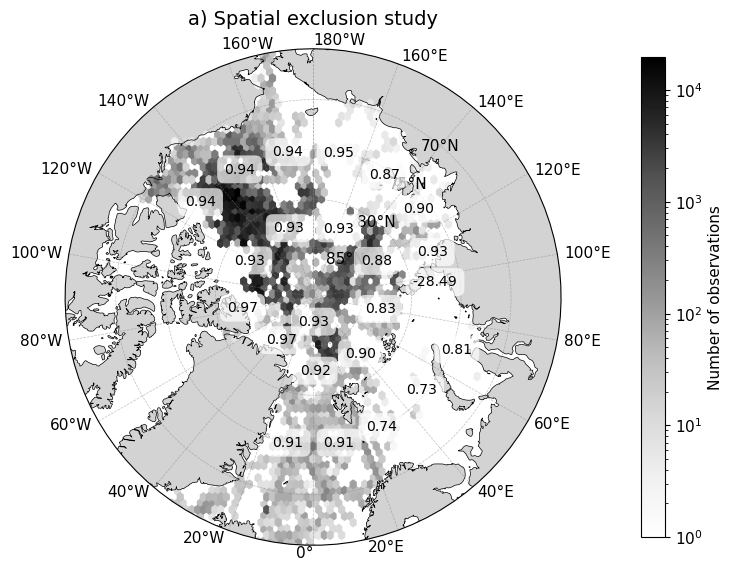

In [ ]:
# Plot the R² scores for each sub-area of spatial exclusion study

r2_scores = {'Region 1': 0.9327848374523233,
 'Region 2': 0.9297023781802415,
 'Region 3': 0.9735057541462874,
 'Region 4': 0.9711425809733178,
 'Region 5': 0.9164569721013839,
 'Region 6': 0.896808365825093,
 'Region 7': 0.8293465519967219,
 'Region 8': 0.8787289038965306,
 'Region 9': 0.9289879675491646,
 'Region 10': 0.9251007658551371,
 'Region 11': 0.9381867943807581,
 'Region 13': 0.9383878603289442,
 'Region 14': 0.9378957499549698,
 'Region 20': 0.9148076764222196,
 'Region 21': 0.908542600535767,
 'Region 22': 0.7377045153801345,
 'Region 23': 0.7328051618563926,
 'Region 24': 0.8132635613665661,
 'Region 25': -28.49013468431365,
 'Region 26': 0.9321074267073367,
 'Region 27': 0.900091958782046,
 'Region 28': 0.8690315416964111,
 'Region 29': 0.9486601152283306}

sub_areas = {
    "Region 1": (training_data['latitude'] > 85),
    "Region 2": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -140) & (training_data['longitude'] < -100),
    "Region 3": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -100) & (training_data['longitude'] < -60),
    "Region 4": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -60) & (training_data['longitude'] < -20),
    "Region 5": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > -20) & (training_data['longitude'] < 20),
    "Region 6": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 20) & (training_data['longitude'] < 60),
    "Region 7": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 60) & (training_data['longitude'] < 100),
    "Region 8": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 100) & (training_data['longitude'] < 140),
    "Region 9": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                (training_data['longitude'] > 140) & (training_data['longitude'] < 180),
    "Region 10": (training_data['latitude'] > 80) & (training_data['latitude'] < 85) & 
                 (training_data['longitude'] > -180) & (training_data['longitude'] < -140),
    "Region 11": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) & 
                (training_data['longitude'] > -180) & (training_data['longitude'] < -160),
    "Region 13": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -160) & (training_data['longitude'] < -140),
    "Region 14": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                (training_data['longitude'] > -140) & (training_data['longitude'] < -120),
    "Region 20": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                 (training_data['longitude'] > -20) & (training_data['longitude'] < 0),
    "Region 21": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 0) & (training_data['longitude'] < 20),
    "Region 22": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 20) & (training_data['longitude'] < 40),
    "Region 23": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 40) & (training_data['longitude'] < 60),
    "Region 24": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 60) & (training_data['longitude'] < 80),
    "Region 25": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 80) & (training_data['longitude'] < 100),
    "Region 26": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 100) & (training_data['longitude'] < 120),
    "Region 27": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 120) & (training_data['longitude'] < 140),
    "Region 28": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &  
                    (training_data['longitude'] > 140) & (training_data['longitude'] < 160),
    "Region 29": (training_data['latitude'] > 70) & (training_data['latitude'] < 80) &
                    (training_data['longitude'] > 160) & (training_data['longitude'] < 180)
}

# Plot the R² scores for each sub-period of the temporal exclusion study

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_r2_scores_on_arctic_map(r2_scores, sub_areas, data):
    # Create figure and specify the map projection
    fig = plt.figure(figsize=(8, 14))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    # Customize the map by adding features
    ax.coastlines(resolution='50m', linewidth=0.5)
    gl = ax.gridlines(drNCW_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Set the extent of the map to focus on the Arctic region
    ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())

    # Compute a circle boundary for the map
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add a title to the plot
    ax.set_title('a) Spatial exclusion study', fontsize=14)

    # Create the 2D histogram using hexbin
    hb = ax.hexbin(
        data['longitude'],
        data['latitude'], 
        gridsize=(100), # Adjust the gridsize to your preference
        cmap='Greys', # Choose the colormap you prefer
        transform=ccrs.PlateCarree(),
        bins='log'
    )

    # Add colorbar
    cbar = plt.colorbar(hb, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Number of observations', fontsize=11)
    cbar.ax.tick_params(labelsize=11)

    # Make colorbar height same as plot
    ax_size = ax.get_position()
    cbar.ax.set_position([ax_size.x1 + 0.1, ax_size.y0, 0.03, ax_size.height])

    # DrNCW region boundaries and place R2 values
    for i, (region_name, region_mask) in enumerate(sub_areas.items()):
        # Get the longitude and latitude bounds for the current region
        lon_min = training_data['longitude'][region_mask].min()
        lon_max = training_data['longitude'][region_mask].max()
        lat_min = training_data['latitude'][region_mask].min()
        lat_max = training_data['latitude'][region_mask].max()
        
        # DrNCW the rectangle representing the region
        #rect = plt.Rectangle(
        #    (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
        #    linewidth=1, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()
        #)
        #ax.add_patch(rect)
        
        # Get the mean longitude and latitude to place the R2 score
        lon_mean = (lon_min + lon_max) / 2
        lat_mean = (lat_min + lat_max) / 2
        
        # Annotate the R2 score in the center of the region
        ax.text(
            lon_mean, lat_mean, f'{r2_scores[i]:.2f}',
            transform=ccrs.PlateCarree(), fontsize=10, ha='center', va='center',
            #fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
        )

    # Adjust longitude and latitude labels
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 11, 'color': 'k', 'rotation': 0}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(65, 91, 5))
    gl.ylabel_style = {'size': 11, 'color': 'k', 'rotation': 0}

    plt.show()

# Example usage:
# Assuming r2_scores is a list of R² values corresponding to the regions in sub_areas
r2_scores = list(r2_scores.values())
plot_r2_scores_on_arctic_map(r2_scores, sub_areas, training_data)


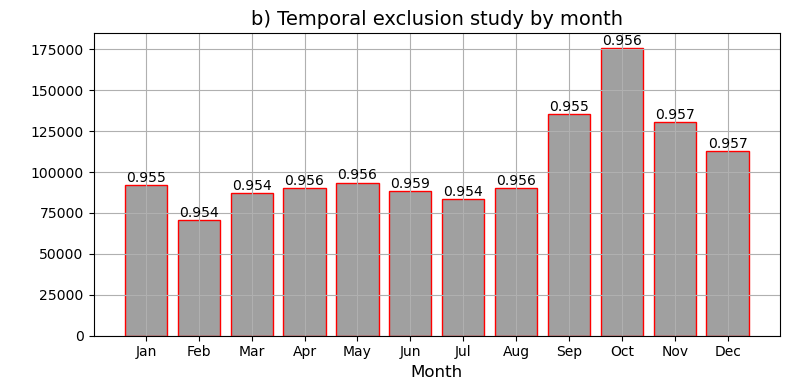

In [116]:
# Load R2 values from temporal exclusion study

r2_scores = {'Jan': 0.954962670210008,
 'Feb': 0.9537843795249726,
 'Mar': 0.9537589811565484,
 'Apr': 0.9562040497312106,
 'May': 0.9559963736601942,
 'Jun': 0.9589371128773037,
 'Jul': 0.9543171887548647,
 'Aug': 0.9559366289886407,
 'Sep': 0.9553050815387801,
 'Oct': 0.9560094719279176,
 'Nov': 0.9572952097752774,
 'Dec': 0.9566993140211194}

# Function to create histplot for months
import seaborn as sn
def plot_hist_by_months(data, r2_scores):


    fig, ax = plt.subplots(figsize=(8, 4))
    sn.histplot(data['month'], bins=range(1, 14), discrete=True, ax=ax, shrink=0.8, color='grey', edgecolor='red')

    # Annotate R² values inside the bars
    months = list(r2_scores.keys())
    for i, month_name in enumerate(months):
        ax.text(i + 1, data['month'].value_counts().sort_index()[i+1] + 50, f'{r2_scores[month_name]:.3f}',
                ha='center', va='bottom', fontsize=10,color='black')
    # Set x-axis labels to the month names
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)

    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel(' ', fontsize=12)
    ax.set_title('b) Temporal exclusion study by month', fontsize=14)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


plot_hist_by_months(training_data,r2_scores)

/var/folders/zn/185xql1x357249zc9q1yjqvm0000gq/T/ipykernel_8450/2816411462.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_tick_labels, fontsize=10)


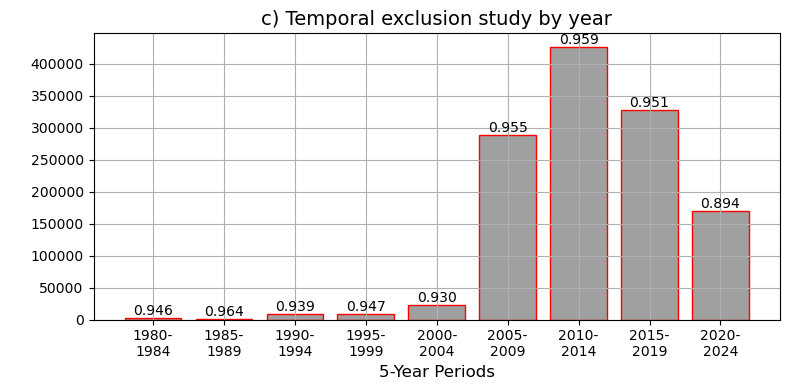

In [115]:
# Load R² scores for each 5-year period of the temporal exclusion study

r2_scores = {'1980-1984': 0.9459028387460032,
 '1985-1989': 0.9642202080207412,
 '1990-1994': 0.9385956263131662,
 '1995-1999': 0.9470061791072594,
 '2000-2004': 0.92971640350995,
 '2005-2009': 0.9554168016380729,
 '2010-2014': 0.9589447607810738,
 '2015-2019': 0.9510257000467407,
 '2020-2024': 0.8936564107940929}

# Plot the R² scores for each 5-year period of the temporal exclusion study

# Function to create histplot for 5-year periods with R² values
def plot_hist_by_5_year_periods(data, r2_scores):
    # Create a new column '5_year_period' that categorizes the years into 5-year bins
    bins = pd.cut(
        data['year'], 
        bins=[1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025], 
        labels=['1980-1984', '1985-1989', '1990-1994', '1995-1999', '2000-2004', 
                '2005-2009', '2010-2014', '2015-2019', '2020-2024'], 
        right=False
    )
    data['5_year_period'] = bins

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    sn.histplot(data['5_year_period'], discrete=True, ax=ax, color="grey", edgecolor='red',shrink=0.8)

    # Annotate R² values inside the bars
    periods = list(r2_scores.keys())
    value_counts = data['5_year_period'].value_counts().sort_index()

    for i, period_name in enumerate(periods):
        if period_name in value_counts.index:
            # Get the height of the bar
            height = value_counts[period_name]
            # Add R² annotation slightly above the bar
            ax.text(i, height + 50, f'{r2_scores[period_name]:.3f}',
                    ha='center', va='bottom', fontsize=10)

    # Set axis labels and title
    ax.set_xlabel('5-Year Periods', fontsize=12)
    ax.set_ylabel(' ', fontsize=12)
    ax.set_title('c) Temporal exclusion study by year', fontsize=14)

    # Modify the tick labels to display on two lines
    new_tick_labels = [label.replace('-', '-\n') for label in data['5_year_period'].cat.categories]
    ax.set_xticklabels(new_tick_labels, fontsize=10)

    # Add grid and improve layout
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_hist_by_5_year_periods(training_data,r2_scores)